### FILE FORMATS

stations.csv

- Station ID (Int)
- WBAN ID (Int) "Weather Bureau Army Navy"
- GPS Latitude (Decimal)
- GPS Longitude (Decimal)

yyyy.csv (yyyy = year)

- StationID (Int)
- WBANID (Int)
- Month (Int)
- Day (Int)
- Temperature / degrees F (Decimal)

Stations are identified by the combination of their Station ID and WBAN ID.
Either of these IDs might be NULL.


In [2]:
from pyspark.sql.functions import lit, expr, col, udf, sum, min, max, pow
from pyspark.sql.types import FloatType
from pyspark.sql import SparkSession
from haversine import haversine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import findspark
findspark .init()

# Cape Canaveral's latitude and longitude coordinates
CC_lat = 28.397
CC_long = -80.606

In [3]:
# Create a spark session
spark = SparkSession.builder.appName('assignment5').getOrCreate()


In [4]:
stations_col_names = ['StationID', 'Station_WBAN_ID',
                      'GPS Latitude', 'GPS Longitude']

# read in data for stations
station_data = spark.read.csv('stations.csv', header=False, inferSchema=True)

# name each column
station_data = station_data.select(
    [col(c).alias(stations_col_names[i]) for i, c in enumerate(station_data.columns)])

# drop rows in "GPS Latitude" and "GPS Longitude" if there are null values
station_data = station_data.na.drop(subset=["GPS Latitude", "GPS Longitude"])

# only contain unique combinations of gps coordinates
station_data = station_data.dropDuplicates(["StationID"])

# create a udf that calculates the distance between Cape Canaveral and the station's coordinates
haversine_udf = udf(lambda lat, lon: haversine(
    (CC_lat, CC_long), (lat, lon)), FloatType())
station_data = station_data.withColumn("Distance (km)", haversine_udf(
    station_data["GPS Latitude"], station_data["GPS Longitude"]))

# only keep rows that has a distance of less than or equal 100 km
station_data = station_data.filter(col("Distance (km)") <= 100)

# sort stationID in ascending order
station_data = station_data.sort("StationID")

station_data.show()

# Get row count
rows = station_data.count()
print(f"DataFrame Rows count: {rows}")

+---------+---------------+------------+-------------+-------------+
|StationID|Station_WBAN_ID|GPS Latitude|GPS Longitude|Distance (km)|
+---------+---------------+------------+-------------+-------------+
|   720904|            299|      29.067|      -81.283|     99.53713|
|   722011|          92813|       28.29|      -81.437|      82.1911|
|   722040|          12838|      28.101|      -80.644|    33.123543|
|   722045|          12843|      27.653|      -80.243|    90.075714|
|   722046|          12898|      28.517|        -80.8|    23.189085|
|   722050|          12815|      28.434|      -81.325|     70.43712|
|   722051|          12841|      28.545|      -81.333|    72.942604|
|   722053|          12841|      28.545|      -81.333|    72.942604|
|   722056|          12834|      29.183|      -81.048|     97.43651|
|   722057|          12854|       28.78|      -81.244|      75.4593|
|   722058|           null|       29.07|       -80.92|     80.85473|
|   722361|          92808|      2

In [5]:
nte6_col_names = ['StationID', 'WBAN_ID', 'Month', 'Day', 'Temperature (F)']

# read in 1986 data
nte6_data = spark.read.csv('1986.csv', header=False, inferSchema=True)

nte6_data = nte6_data.select([col(c).alias(nte6_col_names[i])
                             for i, c in enumerate(nte6_data.columns)])

# drop rows in "StationID", "Month", "Day" and "Temperature (F)" if there are null values
nte6_data = nte6_data.na.drop(
    subset=["StationID", "Month", "Day", "Temperature (F)"])

nte6_data.show()

# Get row count
rows = nte6_data.count()
print(f"DataFrame Rows count: {rows}")

+---------+-------+-----+---+---------------+
|StationID|WBAN_ID|Month|Day|Temperature (F)|
+---------+-------+-----+---+---------------+
|    10010|   null|    1|  1|           17.2|
|    10010|   null|    1|  2|           12.1|
|    10010|   null|    1|  3|           10.4|
|    10010|   null|    1|  4|           17.4|
|    10010|   null|    1|  5|           26.5|
|    10010|   null|    1|  6|           30.1|
|    10010|   null|    1|  7|           29.7|
|    10010|   null|    1|  8|           29.6|
|    10010|   null|    1|  9|           29.6|
|    10010|   null|    1| 10|           33.0|
|    10010|   null|    1| 11|           32.5|
|    10010|   null|    1| 12|           27.4|
|    10010|   null|    1| 13|           22.2|
|    10010|   null|    1| 14|           11.3|
|    10010|   null|    1| 15|            2.5|
|    10010|   null|    1| 16|            3.0|
|    10010|   null|    1| 17|           13.4|
|    10010|   null|    1| 18|           29.8|
|    10010|   null|    1| 19|     

In [6]:
# Join the stations dataframe with the 1986 dataframe on StationID
joined_df = station_data.join(nte6_data, on='StationID').select(col('StationID'), col(
    'WBAN_ID'), col('Month'), col('Day'), col('Temperature (F)'), col('Distance (km)'))

# Only want the data for January 1986
jan_df = joined_df.filter(col("Month") == 1)

jan_df.show()

# Get row count
rows = jan_df.count()
print(f"DataFrame Rows count: {rows}")

+---------+-------+-----+---+---------------+-------------+
|StationID|WBAN_ID|Month|Day|Temperature (F)|Distance (km)|
+---------+-------+-----+---+---------------+-------------+
|   722040|  12838|    1|  1|           65.0|    33.123543|
|   722040|  12838|    1|  2|           67.1|    33.123543|
|   722040|  12838|    1|  3|           64.5|    33.123543|
|   722040|  12838|    1|  4|           67.6|    33.123543|
|   722040|  12838|    1|  5|           63.0|    33.123543|
|   722040|  12838|    1|  6|           51.0|    33.123543|
|   722040|  12838|    1|  7|           64.1|    33.123543|
|   722040|  12838|    1|  8|           63.5|    33.123543|
|   722040|  12838|    1|  9|           65.3|    33.123543|
|   722040|  12838|    1| 10|           68.7|    33.123543|
|   722040|  12838|    1| 11|           63.1|    33.123543|
|   722040|  12838|    1| 12|           56.0|    33.123543|
|   722040|  12838|    1| 13|           54.9|    33.123543|
|   722040|  12838|    1| 14|           

In [7]:
power = 2

# only choose January 28th rows
tw8_jan_df = jan_df.filter(col("Day") == 28)

# numerator = temperature / (distance)^2
tw8_jan_df = tw8_jan_df.withColumn(
    'numerator', tw8_jan_df['Temperature (F)'] / pow(tw8_jan_df['Distance (km)'], power))

# denominator = 1 / (distance)^2
tw8_jan_df = tw8_jan_df.withColumn(
    'denominator', 1 / pow(tw8_jan_df['Distance (km)'], power))

# collect the numerator sum
numerator_sum = tw8_jan_df.groupBy().sum('numerator').collect()[0][0]

# collect the denominator sum
denominator_sum = tw8_jan_df.groupBy().sum('denominator').collect()[0][0]

# sum of numerator / sum of denominator
IDW_val = numerator_sum / denominator_sum

tw8_jan_df.show()
print("Estimated temperature at Cape Canaveral on January 28, 1986 using IDW: ", IDW_val, " °F")

+---------+-------+-----+---+---------------+-------------+--------------------+--------------------+
|StationID|WBAN_ID|Month|Day|Temperature (F)|Distance (km)|           numerator|         denominator|
+---------+-------+-----+---+---------------+-------------+--------------------+--------------------+
|   722040|  12838|    1| 28|           33.7|    33.123543|0.030715411516202915|9.114365435075048E-4|
|   722045|  12843|    1| 28|           37.5|    90.075714|0.004621849930595831|1.232493314825555E-4|
|   722046|   null|    1| 28|           37.0|    23.189085| 0.06880729720864233|0.001859656681314...|
|   722050|  12815|    1| 28|           34.7|     70.43712|0.006994011016689328|2.015565134492601...|
|   722051|  12841|    1| 28|           15.3|    72.942604|0.002875602837741...|1.879478978916097...|
|   722056|  12834|    1| 28|           31.8|     97.43651|0.003349528646292025|1.053310895060385...|
|   722057|  12854|    1| 28|           33.4|      75.4593|0.005865714960602048|1.

In [8]:
def jan_idw(power, df):
    """
    Input: Take in a desired power and a dataframe

    Output: Return a list of IDW_val for every day
    """

    IDW_ls = []

    for i in range(1, 32):

        # only choose January i rows
        day_jan_df = jan_df.filter(col("Day") == i)

        # numerator = temperature / (distance)^2
        day_jan_df = day_jan_df.withColumn(
            'numerator', day_jan_df['Temperature (F)'] / pow(day_jan_df['Distance (km)'], power))

        # denominator = 1 / (distance)^2
        day_jan_df = day_jan_df.withColumn(
            'denominator', 1 / pow(day_jan_df['Distance (km)'], power))

        # collect the numerator sum
        numerator_sum = day_jan_df.groupBy().sum('numerator').collect()[0][0]

        # collect the denominator sum
        denominator_sum = day_jan_df.groupBy().sum(
            'denominator').collect()[0][0]

        # sum of numerator / sum of denominator
        IDW_val = numerator_sum / denominator_sum

        IDW_ls.append(IDW_val)

    return IDW_ls


jan_IDW_list = jan_idw(power, jan_df)

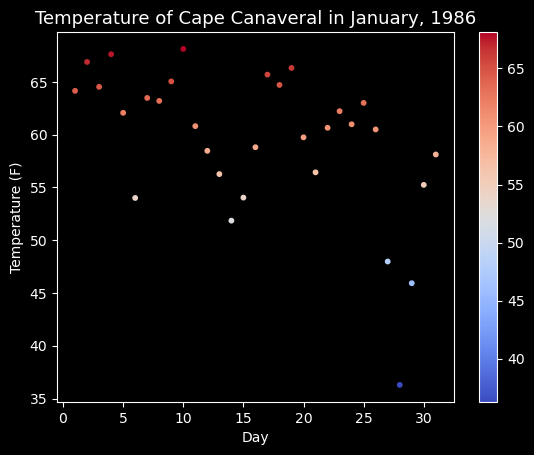

In [9]:
plt.style.use('dark_background')
plt.scatter(range(1, len(jan_IDW_list) + 1), jan_IDW_list,
            marker='o', s=10, c=jan_IDW_list, cmap='coolwarm')
plt.title('Temperature of Cape Canaveral in January, 1986', fontsize=13)
plt.xlabel('Day')
plt.ylabel('Temperature (F)')
plt.grid(False)
plt.colorbar()
plt.show()

In the course of my research and exploration into aerospace technology and mission preparedness, I delved into the historical context of the Challenger disaster. Analyzing this pivotal event from a software engineering perspective, I sought to identify how technological advancements and meticulous planning could mitigate risks and enhance mission safety.

Through a deep investigation, I evaluated the role of weather conditions in the Challenger launch and how it affected critical components like the rubber O-ring seals. This analysis highlighted the significance of meticulous timing and decision-making in launching complex vehicles into space, underscoring the importance of minimizing risk factors to ensure a successful mission.

In envisioning the potential for safer surface-to-space missions, I recognized the value of an AI-powered checklist to assist engineers in evaluating and mitigating risks comprehensively. This forward-looking perspective aligns with ABL Space Systems' commitment to innovation and safety, envisioning a future where aerospace missions are conducted with heightened precision and security.

My eagerness to contribute to ABL Space Systems stems from this insight, and I am excited about the opportunity to apply my software engineering skills to advance the stability and success of space missions. I am committed to leveraging technology to facilitate more informed decision-making and drive the aerospace industry towards a safer and more efficient future.
